In [1]:
import pandas as pd

In [2]:
train = pd.read_csv("./data/train.csv")
train.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829


In [3]:
train.shape

(87864, 9)

In [4]:
for col in train:
    print(col, train[col].nunique(), '\n')

Item_ID 895 

Item_W 87283 

Item_Type 16 

Item_MRP 87814 

Outlet_ID 5 

Outlet_Year 12 

Outlet_Size 3 

Outlet_Location_Type 3 

Sales 87760 



In [5]:
pd.DataFrame({
    'Outlet_ID Values': train['Outlet_ID'].value_counts().index,
    'Count': train['Outlet_ID'].value_counts().values
})

,Outlet_ID Values,Count
0,OUT035,24071
1,OUT046,20850
2,OUT018,17156
3,OUT049,13356
4,OUT013,12431


In [6]:
pd.DataFrame({
    'Item_Type Values': train['Item_Type'].value_counts().index,
    'Count': train['Item_Type'].value_counts().values
})

,Item_Type Values,Count
0,Baking Goods,14666
1,Fruits and Vegetables,14328
2,Meat,8099
3,Snack Foods,7817
4,Household,6018
5,Soft Drinks,5396
6,Frozen Foods,5129
7,Canned,4565
8,Dairy,3807
9,Others,3688


In [7]:
pd.DataFrame({
    'Outlet_Size Values': train['Outlet_Size'].value_counts().index,
    'COunt': train['Outlet_Size'].value_counts().values
})

,Outlet_Size Values,COunt
0,Small,48614
1,Medium,26683
2,High,12567


In [8]:

pd.DataFrame({
    'Outlet_Location_Type Values': train['Outlet_Location_Type'].value_counts().index,
    'Count': train['Outlet_Location_Type'].value_counts().values
})

,Outlet_Location_Type Values,Count
0,Tier 1,33567
1,Tier 3,29044
2,Tier 2,25253


array([[<AxesSubplot:title={'center':'Item_W'}>,
        <AxesSubplot:title={'center':'Item_MRP'}>],
       [<AxesSubplot:title={'center':'Outlet_Year'}>,
        <AxesSubplot:title={'center':'Sales'}>]], dtype=object)

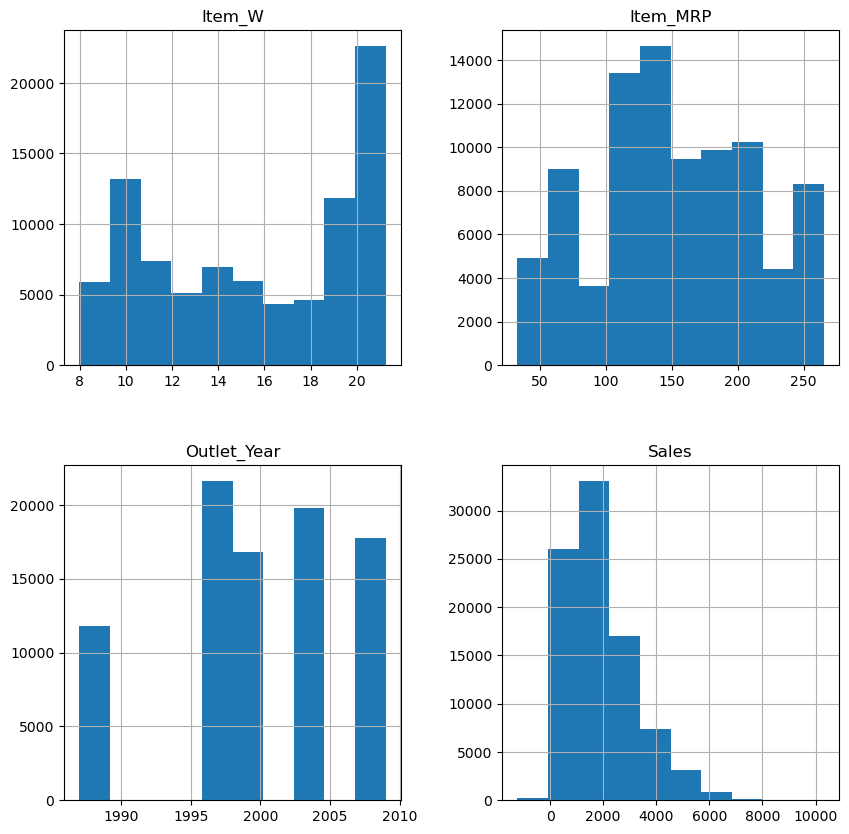

In [9]:
import matplotlib.pyplot as plt

train.hist(figsize=(10, 10))

In [10]:
train.isnull().sum()

Item_ID                 0
Item_W                  0
Item_Type               0
Item_MRP                0
Outlet_ID               0
Outlet_Year             0
Outlet_Size             0
Outlet_Location_Type    0
Sales                   0
dtype: int64

In [11]:
train.dtypes

Item_ID                  object
Item_W                  float64
Item_Type                object
Item_MRP                float64
Outlet_ID                object
Outlet_Year               int64
Outlet_Size              object
Outlet_Location_Type     object
Sales                   float64
dtype: object

### Preprocess Data

In [12]:
numerical_cols = [
    'Item_MRP',
    'Outlet_Year'
]

In [13]:
categorical_cols = [
    'Item_Type', 'Outlet_ID',
    'Outlet_Size', 'Outlet_Location_Type'
]

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [15]:
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encode', OneHotEncoder(handle_unknown = 'ignore'))
])

In [16]:
# define preprocessing steps
preprocessor = ColumnTransformer(
transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

### Split Data

In [17]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10)

In [18]:
X = train[numerical_cols+categorical_cols]
Y = train['Sales']

### Build & Evalute Model

In [19]:
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', VotingRegressor(
                                  [
                                   ('cat', CatBoostRegressor(iterations=100, verbose=False)),
                                    ('xgb', XGBRegressor(objective ='reg:squarederror')),
                                    ('lgbm', LGBMRegressor())
                                   ],
                              ))
                             ])

In [20]:
total = 0
i = 0
for train_idx, test_idx in kf.split(X):
  X_train, Y_train = X.iloc[train_idx], Y.iloc[train_idx]
  X_test, Y_test = X.iloc[test_idx], Y.iloc[test_idx]

  pipeline.fit(X_train, Y_train)
  y_pred = pipeline.predict(X_test)
  print("\n Fold " + str(i) + " RMSE: ", mean_squared_error(Y_test, y_pred, squared=False))
  total += mean_squared_error(Y_test, y_pred, squared=False)
  i += 1

print('\n Average RMSE: ', total/10)


 Fold 0 RMSE:  1280.4142694051507

 Fold 1 RMSE:  1271.58096565014

 Fold 2 RMSE:  1261.7375653496385

 Fold 3 RMSE:  1299.5447723617472

 Fold 4 RMSE:  1273.8188401189475

 Fold 5 RMSE:  1269.442197116635

 Fold 6 RMSE:  1252.226297471175

 Fold 7 RMSE:  1297.0552756227544

 Fold 8 RMSE:  1303.8050489157313

 Fold 9 RMSE:  1263.931817779325

 Average RMSE:  1277.3557049791245


### Permution Importance

In [21]:
from sklearn.inspection import permutation_importance

result = permutation_importance(pipeline, X_test, Y_test, random_state=0)

In [22]:
pd.DataFrame({'cols': X.columns, "score": result['importances_mean']})

,cols,score
0,Item_MRP,0.004573
1,Outlet_Year,0.020500
2,Item_Type,0.007206
3,Outlet_ID,0.012638
4,Outlet_Size,0.005637
5,Outlet_Location_Type,0.003916


### Total Trainig RMSE

In [23]:
pipeline.fit(X, Y)
y_pred = pipeline.predict(X)
print(mean_squared_error(Y, y_pred, squared=False))

1238.604074856283


### Predictions

In [24]:
test = pd.read_csv('./data/test.csv')
test.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type
0,DRM23,10.156725,Snack Foods,119.319482,OUT013,1999,High,Tier 3
1,FDG47,10.434425,Household,263.600449,OUT018,1987,High,Tier 3
2,FDN21,11.953589,Health and Hygiene,246.286990,OUT018,1997,High,Tier 1
3,FDZ23,14.948546,Dairy,136.200508,OUT046,2004,Medium,Tier 2
4,FDC16,11.080042,Canned,173.145664,OUT018,2009,Medium,Tier 3


In [25]:
# store predictions as dataframe

submission = pd.DataFrame(pipeline.predict(test[categorical_cols+numerical_cols]))
submission.index = test.index
submission.colums = ['Sales']
#submission.head()

C:\Users\satya\AppData\Local\Temp\ipykernel_4828\186409149.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  submission.colums = ['Sales']


In [26]:
submission.to_csv('./data/submission.csv', index=False)

### Actual vs Prediction

In [27]:
import matplotlib.pyplot as plt

y_pred = pipeline.predict(X)

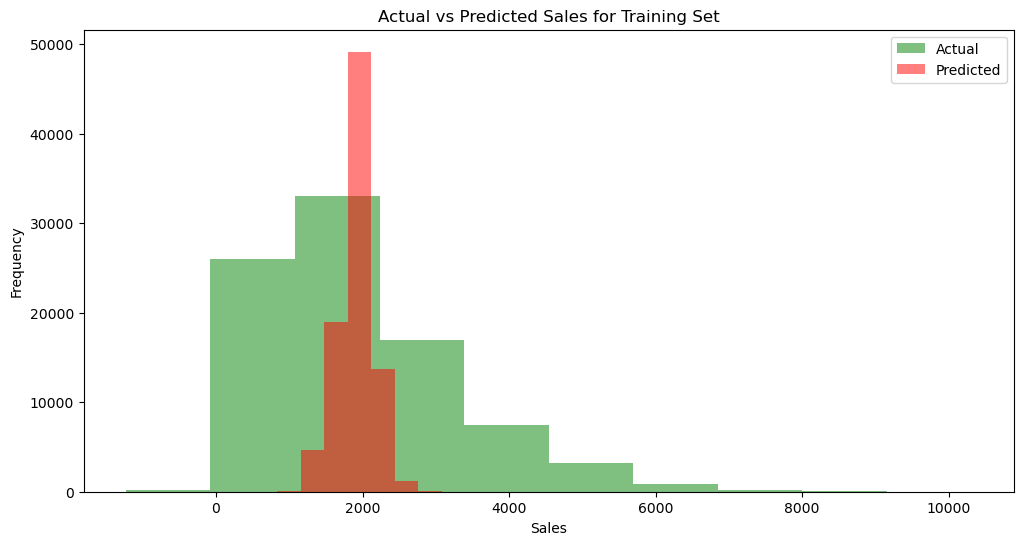

In [28]:
plt.rcParams['figure.figsize'] = (12, 6)
plt.hist(Y, alpha=0.5, color='green', label='Actual')
plt.hist(y_pred, alpha=0.5, color='red', label='Predicted')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Actual vs Predicted Sales for Training Set')
plt.legend()
#plt.savefig('act_vs_pred.png', dpi=600, bbox_inches='tight')